In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import sklearn.preprocessing as sk
from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#function for model fitting
def prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
   
    algo.fit(training_x,training_y)
    print('fitted model')
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]

    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)
        
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)
    
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")
    
    plt.show()

In [40]:
df = pd.read_csv("/content/drive/MyDrive/jobathon/process_data.csv")
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,0.0,73.0,18.0,1.0,2.0,43.0,1.0,1045696.0,0.0,0
1,IDD62UNG,0.0,30.0,27.0,2.0,0.0,32.0,1.0,581988.0,0.0,0
2,HD3DSEMC,0.0,56.0,18.0,3.0,2.0,26.0,1.0,1484315.0,1.0,0
3,BF3NC7KV,1.0,34.0,20.0,2.0,0.0,19.0,1.0,470454.0,0.0,0
4,TEASRWXV,0.0,30.0,32.0,2.0,0.0,33.0,1.0,886787.0,0.0,0


Try SMOTE

In [41]:
sm = SMOTE(random_state=42)
X = df[df.columns[1:-1]]
y = df.Is_Lead
X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
pd.DataFrame(y_sm).value_counts(normalize=True) * 100

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of X before SMOTE: (245725, 9)
Shape of X after SMOTE: (374874, 9)

Balance of positive and negative classes (%):


1    50.0
0    50.0
dtype: float64

In [42]:
df_smote = pd.DataFrame(X_sm,columns = df.columns[1:-1])
df_smote['Is_Lead'] = y_sm

In [12]:
df_smote.to_csv('/content/drive/MyDrive/jobathon/smote_data.csv',index=False)

#train test split

In [43]:
train, test = train_test_split(df_smote, test_size=0.2, random_state=111, stratify = df_smote.Is_Lead)
x = df.columns[1:-1]
y = "Is_Lead"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]


##LGBMClassifier

In [35]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

def cross_val(X, y, model, params, folds=4):

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        alg = model(**params)
        alg.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = alg.predict_proba(x_test)[:, 1]
        roc_score = roc_auc_score(y_test, pred)
        print(f"roc_auc_score: {roc_score}")
        print("-"*50)
    
    return alg
lgb_params= {'learning_rate': 0.05, 
             'n_estimators': 20000, 
             'max_bin': 94,
             'num_leaves': 5, 
             'max_depth': 7, 
             }
from lightgbm import LGBMClassifier
lgb_model = cross_val(train_x, train_y, LGBMClassifier, lgb_params)

Fold: 0
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's binary_logloss: 0.30294
[800]	valid_0's binary_logloss: 0.295433
[1200]	valid_0's binary_logloss: 0.292398
[1600]	valid_0's binary_logloss: 0.290175
[2000]	valid_0's binary_logloss: 0.288943
[2400]	valid_0's binary_logloss: 0.287513
[2800]	valid_0's binary_logloss: 0.28705
[3200]	valid_0's binary_logloss: 0.286732
[3600]	valid_0's binary_logloss: 0.286298
[4000]	valid_0's binary_logloss: 0.2861
[4400]	valid_0's binary_logloss: 0.285916
[4800]	valid_0's binary_logloss: 0.285773
Early stopping, best iteration is:
[5004]	valid_0's binary_logloss: 0.285734
roc_auc_score: 0.9367625530727448
--------------------------------------------------
Fold: 1
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's binary_logloss: 0.303058
[800]	valid_0's binary_logloss: 0.294889
[1200]	valid_0's binary_logloss: 0.291473
[1600]	valid_0's binary_logloss: 0.289653
[2000]	valid_0's binary_logloss:

In [39]:
Y_pred = lgb_model.predict(test_x)
acc_lgb = round(lgb_model.score(train_x, train_y) * 100, 2)
print("Accuracy :",acc_lgb,"\nroc_auc :",roc_auc_score(test_y,Y_pred))

Accuracy : 86.82 
roc_auc : 0.8633400011164492


##ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(criterion='entropy', n_estimators=100, random_state=0,class_weight={0: 1, 1: 2},)
ET_model = clf.fit(train_x, train_y)

In [15]:
Y_pred = ET_model.predict(test_x)
acc_log = round(ET_model.score(train_x, train_y) * 100, 2)
print("Accuracy :",acc_log,"\nroc_auc :",roc_auc_score(test_y,Y_pred))

Accuracy : 100.0 
roc_auc : 0.844254165387663


##Gradient Boost

In [11]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
GBC = GradientBoostingClassifier(n_estimators=100,max_depth=7)
# GBC.fit(train_x, train_y)
# y_pred = GBC.predict(test_x)


fitted model
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     37488
           1       0.93      0.78      0.85     37487

    accuracy                           0.86     74975
   macro avg       0.87      0.86      0.86 

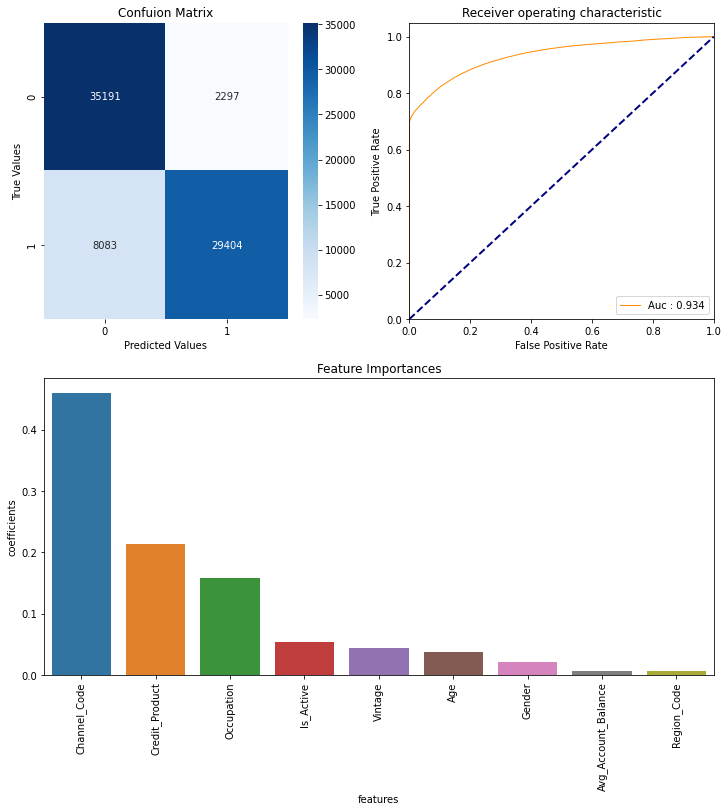

In [47]:
prediction(GBC, train_x, train_y, test_x, test_y, x,"features")

##Ada Boost

In [ ]:
ABC = AdaBoostClassifier(n_estimators=100)
ABC.fit(train_x, train_y)
y_pred = ABC.predict(test_x)
print("Accuracy :",accuracy_score(test_y, y_pred),"\nroc_auc :",roc_auc_score(test_y,y_pred))

fitted model
AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.5,
                   n_estimators=1000, random_state=None)

 Classification report : 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86     37488
           1       0.92      0.77      0.84     37487

    accuracy                           0.85     74975
   macro avg       0.86      0.85      0.85     74975
weighted avg       0.86      0.85      0.85     74975

Accuracy   Score :  0.8525641880626875
Area under curve :  0.9244439338486965 



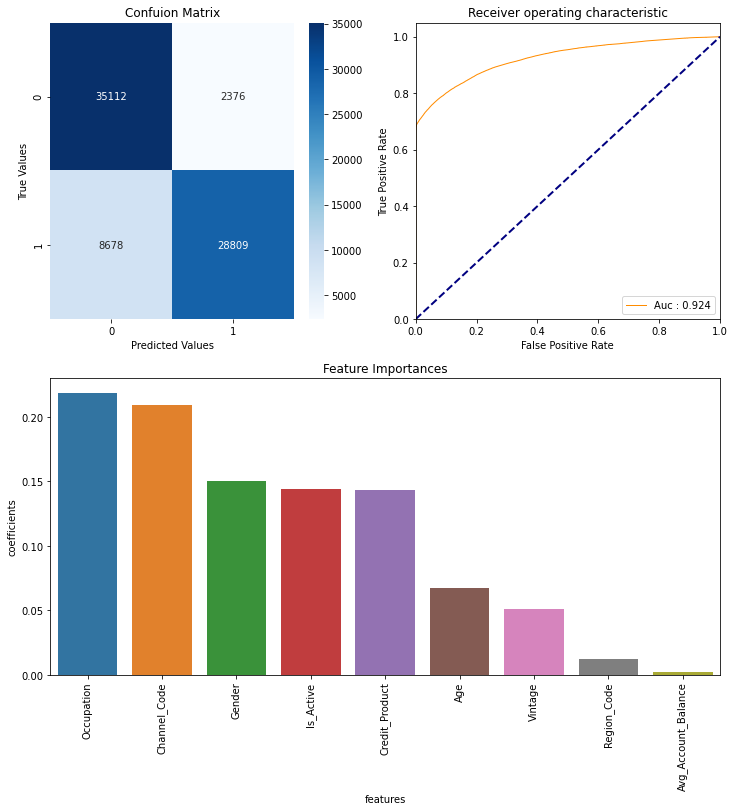

In [13]:
ABC = AdaBoostClassifier(n_estimators=1000, learning_rate=0.5, algorithm='SAMME')
prediction(ABC, train_x, train_y, test_x, test_y, x,"features")

##Logistic reg

In [18]:
logreg = LogisticRegression()
logreg.fit(train_x, train_y)
Y_pred = logreg.predict(test_x)
acc_log = round(logreg.score(train_x, train_y) * 100, 2)
print("Accuracy :",acc_log,"\nroc_auc :",roc_auc_score(test_y,Y_pred))

Accuracy : 50.0 
roc_auc : 0.5


#####Coefficient of the features

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

In [19]:
coeff_df = pd.DataFrame(df.columns[1:-1])
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
7,Avg_Account_Balance,5.160403e-08
5,Vintage,2.801200e-11
1,Age,9.037498e-12
2,Region_Code,1.178953e-12
4,Channel_Code,7.283404e-13
6,Credit_Product,2.609980e-13
8,Is_Active,1.205002e-13
0,Gender,8.914462e-14
3,Occupation,-8.031582e-14


##Bayes

In [20]:
gaussian = GaussianNB()
gaussian.fit(train_x, train_y)
Y_pred = gaussian.predict(test_x)
acc_gaussian = round(gaussian.score(train_x, train_y) * 100, 2)
print("Accuracy :",acc_gaussian,"\nroc_auc :",roc_auc_score(test_y,Y_pred))

Accuracy : 65.56 
roc_auc : 0.6510701960831127


##SGDClassifier

In [21]:
sgd = SGDClassifier()
sgd.fit(train_x, train_y)
Y_pred = sgd.predict(test_x)
acc_sgd = round(sgd.score(train_x, train_y) * 100, 2)
print("Accuracy :",acc_sgd,"\nroc_auc :",roc_auc_score(test_y,Y_pred))

Accuracy : 50.0 
roc_auc : 0.5


#RF Model

In [44]:
rfmodel = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False,)

fitted model
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.64      0.74     37488
           1       0.72      0.93      0.81     37487

    accuracy                           0.78     74975
   macro avg       0.81      0.78      0.78     74975
weighted avg       0.81      0.78      0.78     74975

Accuracy   Score :  0.7808336112037346
Area under curve :  0.917359889983087

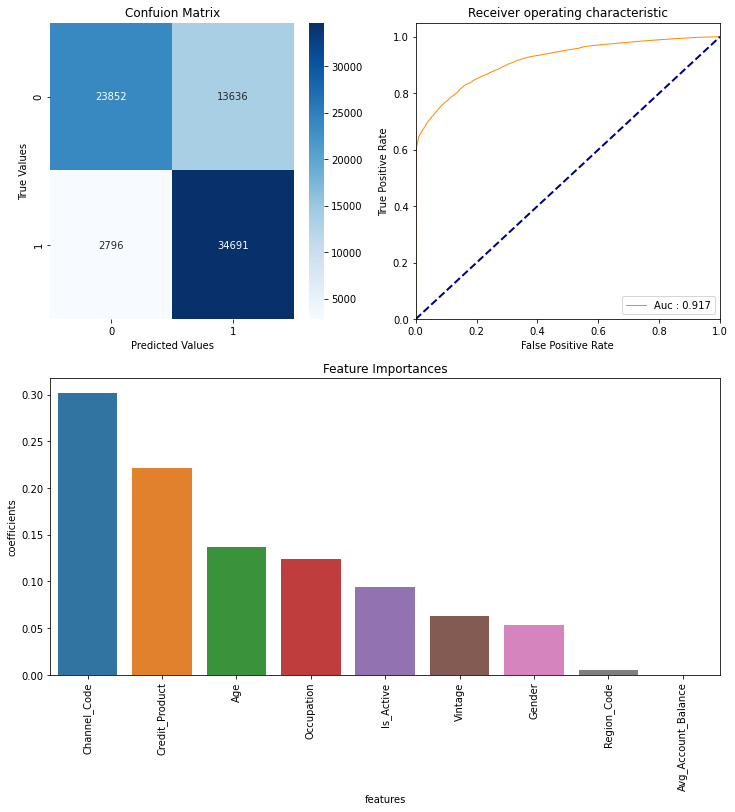

In [45]:
prediction(rfmodel, train_x, train_y, test_x, test_y, x,"features")

#Testing

In [49]:
test_df = pd.read_csv("/content/drive/MyDrive/jobathon/pro_test.csv")
test_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,1.0,29.0,4.0,1.0,0.0,25.0,2.0,742366.0,0.0
1,CCMEWNKY,1.0,43.0,18.0,1.0,1.0,49.0,1.0,925537.0,0.0
2,VK3KGA9M,1.0,31.0,20.0,2.0,0.0,14.0,1.0,215949.0,0.0
3,TT8RPZVC,1.0,29.0,22.0,1.0,0.0,33.0,1.0,868070.0,0.0
4,SHQZEYTZ,0.0,29.0,20.0,1.0,0.0,19.0,1.0,657087.0,0.0


In [50]:
prob = rfmodel.predict_proba(test_df[test_df.columns[1:]])

In [51]:
submission = test_df[['ID']]
submission['Is_Lead'] = prob.T[1]
submission.to_csv("/content/drive/MyDrive/jobathon/sub_finalrf.csv",index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#Trying without CP

fitted model
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.79      0.82     37487
           1       0.45      0.56      0.50     11658

    accuracy                           0.73     49145
   macro avg       0.65      0.67      0.66     49145
weighted avg       0.76      0.73      0.74     49145

Accuracy   Score :  0.7348458642791739
Area under curve :  0.758915956422164

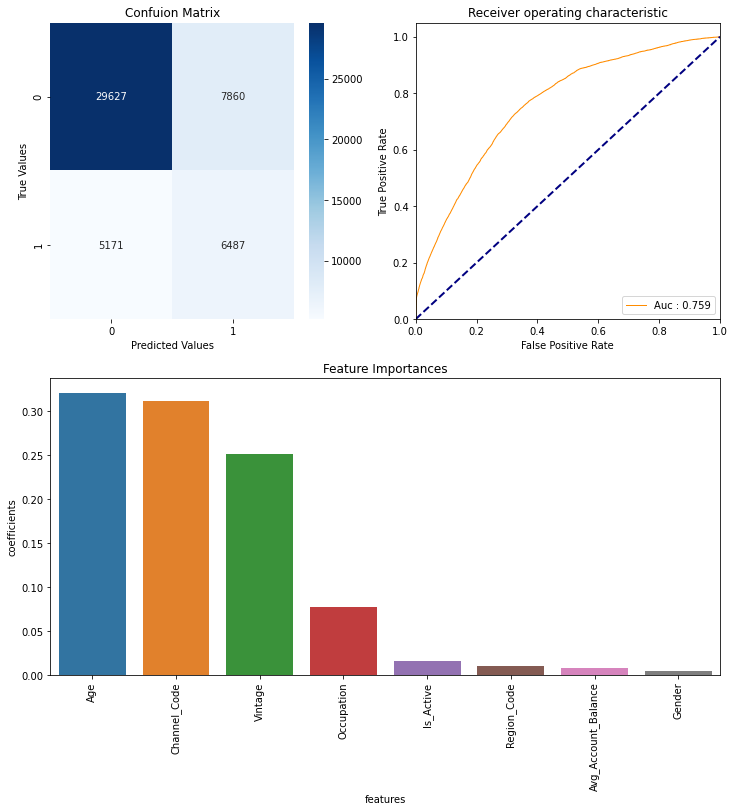

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
data_encoded = pd.read_csv("/content/drive/MyDrive/jobathon/encoded_data.csv")
data_encoded = data_encoded.loc[:, data_encoded.columns!= 'Credit_Product']
train, test = train_test_split(data_encoded, test_size=0.2, random_state=111, stratify = data_encoded.Is_Lead)
x = data_encoded.columns[1:-1]
y = "Is_Lead"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]

prediction(rfmodel, train_x, train_y, test_x, test_y, x,"features")

test_encoded = pd.read_csv("/content/drive/MyDrive/jobathon/encoded_test.csv")
test_encoded = test_encoded.loc[:, test_encoded.columns!= 'Credit_Product']
prob = rfmodel.predict_proba(test_encoded[test_encoded.columns[1:]])

submission = test_df[['ID']]
submission['Is_Lead'] = prob.T[1]
submission.to_csv("/content/drive/MyDrive/jobathon/sub_noimp_rf.csv",index=False)